In [1]:
import pandas as pd
import matplotlib.pyplot as plt
EXPORT_DIR = "data/facteurs_systemiq"



## IMPORT ET PRE TRAITEMENT

In [2]:
EXPORT_DIR = "data/facteurs_systemiq"
Z_hat = pd.read_csv(f"{EXPORT_DIR}/Z_industrie.csv")

In [3]:
# Charger le fichier Excel
df_macro_raw= pd.read_excel("data\macro_data\Données_macro_hist_v2.xlsx")

# Afficher les premières lignes
df_macro_raw

,Region,Variable,Unit,2010-Q1,2010-Q2,2010-Q3,2010-Q4,2011-Q1,2011-Q2,2011-Q3,...,2022-Q4,2023-Q1,2023-Q2,2023-Q3,2023-Q4,2024-Q1,2024-Q2,2024-Q3,2024-Q4,2025-Q1
0,Argentina,Central bank Intervention rate (policy interes...,%,9.500000,9.500000,9.500000,9.500000,9.500000,9.500000,9.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Argentina,Effective exchange rate,index; 2017=100,180.006667,182.946667,181.750000,177.056667,174.323333,167.796667,169.263333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Argentina,Exchange_rate,local currency per US$,3.830000,3.880000,3.920000,3.950000,3.990000,4.060000,4.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Argentina,GDP Growth Rate,%,3.131891,4.307855,0.557817,1.184901,2.388622,1.192061,0.842933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,Central bank Intervention rate (policy interes...,%,3.833333,4.416667,4.500000,4.666667,4.750000,4.750000,4.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,United States,Inflation rate,%,2.360525,1.767765,1.175609,1.270248,2.141127,3.430395,3.756174,...,7.103384,5.810245,3.982369,3.514197,3.243513,3.240480,3.199263,2.622039,2.745114,2.737586
247,United States,Long term interest rate,%,3.716667,3.490000,2.786667,2.863333,3.460000,3.210000,2.426667,...,3.830000,3.646667,3.593333,4.150000,4.440000,4.160000,4.443333,3.946667,4.283333,4.453333
248,United States,Oil price,US$ per barrel,76.674837,78.845036,76.675000,87.033160,105.369424,117.541905,113.266948,...,88.720130,82.323613,78.086130,85.983547,82.891681,81.955714,84.981986,78.708317,74.000940,75.042781
249,United States,Unemployment rate,%,9.833333,9.633333,9.466666,9.500000,9.033334,9.066667,9.000000,...,3.566667,3.533333,3.533333,3.666667,3.800000,3.833333,4.000000,4.166667,4.133333,4.100000


In [4]:
df = df_macro_raw.copy()

id_cols = ["Region", "Variable", "Unit"]
value_cols = [c for c in df.columns if c not in id_cols]

df_long = df.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="quarter",
    value_name="value"
)

df_long.head()

,Region,Variable,Unit,quarter,value
0,Argentina,Central bank Intervention rate (policy interes...,%,2010-Q1,9.500000
1,Argentina,Effective exchange rate,index; 2017=100,2010-Q1,180.006667
2,Argentina,Exchange_rate,local currency per US$,2010-Q1,3.830000
3,Argentina,GDP Growth Rate,%,2010-Q1,3.131891
4,Australia,Central bank Intervention rate (policy interes...,%,2010-Q1,3.833333


Nous allons récupérer les variables macroéconomiques à considérer pour la modélisation des facteurs systémiques. D'abord, au regard des données dont nous disposons, nous ne pouvons considérer que les variables provenant des régions d'EUrope (5 variables disponibles) et des US (9 variables disponibles).

In [5]:
# Sélection des régions
regions_keep = ["United States"]
df = df_macro_raw[df_macro_raw["Region"].isin(regions_keep)].copy()

In [6]:
# Colonnes temporelles
time_cols = [c for c in df.columns if "-" in c]
# On garde uniquement les lignes sans NaN sur toute la période
df = df.dropna(subset=time_cols)

In [7]:
# Mapping régions → suffixes
region_map = {
    "United States": "US"
}

def clean_var_name(var):
    return (
        var.strip()
           .replace(" ", "_")
           .replace("(", "")
           .replace(")", "")
           .replace("/", "_")
    )

df["var_name"] = (
    df["Region"].map(region_map)
    + "_"
    + df["Variable"].apply(clean_var_name)
)

In [8]:
# Passage au format long
df_long = df.melt(
    id_vars=["var_name"],
    value_vars=time_cols,
    var_name="date",
    value_name="value"
)

# Pivot final
df_ts = df_long.pivot(
    index="date",
    columns="var_name",
    values="value"
).sort_index()

In [9]:
# Conversion "2010-Q1" → PeriodIndex trimestriel
df_ts.index = pd.PeriodIndex(df_ts.index, freq="Q").to_timestamp()

In [10]:
df_ts.head()

var_name,US_Central_bank_Intervention_rate_policy_interest_rate,US_Effective_exchange_rate,US_Equity_prices,US_GDP_Growth_Rate,US_House_prices_residential,US_Inflation_rate,US_Long_term_interest_rate,US_Oil_price,US_Unemployment_rate
date,,,,,,,,,
2010-01-01,0.125,84.740000,46.875171,0.484501,94.481014,2.360525,3.716667,76.674837,9.833333
2010-04-01,0.125,86.106667,41.314746,0.967586,93.876843,1.767765,3.490000,78.845036,9.633333
2010-07-01,0.125,84.923333,45.743602,0.771085,92.137491,1.175609,2.786667,76.675000,9.466666
2010-10-01,0.125,81.390000,50.410959,0.525110,90.641295,1.270248,2.863333,87.033160,9.500000
2011-01-01,0.125,80.343333,53.144269,-0.237205,87.908116,2.141127,3.460000,105.369424,9.033334


In [11]:
Z_hat.head()

,Unnamed: 0,Zt
0,2010-07-01,0.853099
1,2010-10-01,0.225867
2,2011-01-01,0.120603
3,2011-04-01,0.165188
4,2011-07-01,-0.284736


In [12]:
Z_hat = Z_hat.rename(columns={"Unnamed: 0": "date"})
Z_hat["date"] = pd.to_datetime(Z_hat["date"])
Z_hat = Z_hat.set_index("date")

In [13]:
df_merged = df_ts.join(Z_hat, how="right")

DATA FRAME FUSIONNE

## STATIONARITÉ

### TESTS DE STATIONNARITE

In [14]:
import numpy as np
import pandas as pd
import warnings

from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests_summary(
    df: pd.DataFrame,
    variables=None,
    adf_alpha: float = 0.05,
    kpss_alpha: float = 0.05,
    kpss_regression: str = "c",
    autolag: str = "AIC",
    dropna: bool = True,
    min_n: int = 20
) -> pd.DataFrame:
    """
    Calcule ADF + KPSS pour une liste de variables, renvoie un tableau récapitulatif
    avec p-values, décisions à 5% et diagnostic.

    Parameters
    ----------
    df : DataFrame (wide) avec colonnes = variables.
    variables : list[str] ou None (par défaut: toutes les colonnes numériques).
    adf_alpha : seuil de rejet ADF (H0 = non-stationnaire).
    kpss_alpha : seuil de rejet KPSS (H0 = stationnaire).
    kpss_regression : 'c' (stationnaire autour d'une constante) ou 'ct' (constante+tendance).
    autolag : méthode de sélection du lag pour ADF ('AIC','BIC','t-stat',None).
    dropna : supprime les NA avant tests.
    min_n : taille minimale requise pour lancer les tests.

    Returns
    -------
    DataFrame avec colonnes:
    variable, n, adf_pvalue, kpss_pvalue, ADF_stationary_5pct, KPSS_stationary_5pct, diagnosis
    """
    if variables is None:
        # par défaut: toutes les colonnes numériques
        variables = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        variables = list(variables)

    results = []

    for var in variables:
        if var not in df.columns:
            results.append({
                "variable": var, "n": 0,
                "adf_pvalue": np.nan, "kpss_pvalue": np.nan,
                "ADF_stationary_5pct": np.nan, "KPSS_stationary_5pct": np.nan,
                "diagnosis": "Missing"
            })
            continue

        s = df[var]
        s = s.dropna() if dropna else s

        # Cast float (évite certains soucis)
        s = pd.to_numeric(s, errors="coerce").dropna()

        n = len(s)

        # Cas série trop courte / constante
        if n < min_n or s.nunique() <= 1:
            results.append({
                "variable": var, "n": n,
                "adf_pvalue": np.nan, "kpss_pvalue": np.nan,
                "ADF_stationary_5pct": np.nan, "KPSS_stationary_5pct": np.nan,
                "diagnosis": "Insufficient/Constant"
            })
            continue

        # -------- ADF --------
        adf_p = np.nan
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                adf_out = adfuller(s.values, autolag=autolag)
            adf_p = float(adf_out[1])
        except Exception:
            adf_p = np.nan

        # -------- KPSS --------
        kpss_p = np.nan
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                kpss_out = kpss(s.values, regression=kpss_regression, nlags="auto")
            kpss_p = float(kpss_out[1])
        except Exception:
            kpss_p = np.nan

        # Décisions
        # ADF: rejeter H0 (non-stationnaire) si p < alpha => stationnaire
        adf_stationary = (adf_p < adf_alpha) if not np.isnan(adf_p) else np.nan
        # KPSS: rejeter H0 (stationnaire) si p < alpha => non stationnaire
        # donc stationnaire si p > alpha
        kpss_stationary = (kpss_p > kpss_alpha) if not np.isnan(kpss_p) else np.nan

        # Diagnostic combiné
        if adf_stationary is True and kpss_stationary is True:
            diag = "Stationary"
        elif adf_stationary is False and kpss_stationary is False:
            diag = "Non-stationary"
        elif (adf_stationary is np.nan) or (kpss_stationary is np.nan):
            diag = "Test failed"
        else:
            diag = "Ambiguous"

        results.append({
            "variable": var,
            "n": n,
            "adf_pvalue": adf_p,
            "kpss_pvalue": kpss_p,
            "ADF_stationary_5pct": adf_stationary,
            "KPSS_stationary_5pct": kpss_stationary,
            "diagnosis": diag
        })

    out = pd.DataFrame(results)

    # Optionnel: trier pour lecture (Non-stationary / Ambiguous / Stationary)
    order = pd.CategoricalDtype(
        categories=["Non-stationary", "Ambiguous", "Stationary", "Insufficient/Constant", "Missing", "Test failed"],
        ordered=True
    )
    if "diagnosis" in out.columns:
        out["diagnosis"] = out["diagnosis"].astype(order)

    return out


In [15]:
variables = df_merged.columns.tolist()
stationarity_df = stationarity_tests_summary(df_merged, variables)
stationarity_df


,variable,n,adf_pvalue,kpss_pvalue,ADF_stationary_5pct,KPSS_stationary_5pct,diagnosis
0,US_Central_bank_Intervention_rate_policy_inter...,52,9.558478e-01,0.032165,False,False,Non-stationary
1,US_Effective_exchange_rate,52,7.498459e-01,0.010000,False,False,Non-stationary
2,US_Equity_prices,52,9.990653e-01,0.010000,False,False,Non-stationary
3,US_GDP_Growth_Rate,52,4.104503e-16,0.100000,True,True,Stationary
4,US_House_prices_residential,52,9.990518e-01,0.010000,False,False,Non-stationary
5,US_Inflation_rate,52,9.059152e-01,0.048839,False,False,Non-stationary
6,US_Long_term_interest_rate,52,6.380375e-03,0.100000,True,True,Stationary
7,US_Oil_price,52,3.503973e-01,0.072186,False,True,Ambiguous
8,US_Unemployment_rate,52,6.868225e-02,0.018192,False,False,Non-stationary
9,Zt,52,2.070547e-01,0.100000,False,True,Ambiguous


Resultats des tests de stationnarité: plusieurs variables macro non stationnaires

### STATIONNARISATION

In [16]:
df_merged.columns

Index(['US_Central_bank_Intervention_rate_policy_interest_rate',
       'US_Effective_exchange_rate', 'US_Equity_prices', 'US_GDP_Growth_Rate',
       'US_House_prices_residential', 'US_Inflation_rate',
       'US_Long_term_interest_rate', 'US_Oil_price', 'US_Unemployment_rate',
       'Zt'],
      dtype='object')

In [17]:
import numpy as np
import pandas as pd

TRANSFORMATIONS = {
    # Interest rates -> difference
    "US_Central_bank_Intervention_rate_policy_interest_rate": "diff",
    "US_Long_term_interest_rate": "diff",

    # Unemployment & inflation -> difference
    "US_Unemployment_rate": "diff",
    "US_Inflation_rate": "diff",

    # Exchange rates -> log ratio
    "US_Effective_exchange_rate": "log_ratio",

    # Prices -> log ratio
    "US_Equity_prices": "log_ratio",
    "US_House_prices_residential": "log_ratio",
    "US_Oil_price": "log_ratio",

    # GDP growth rates -> keep (already stationary in your tests)
    "US_GDP_Growth_Rate": "level",
}


In [18]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss

def _adf_kpss(series, regression="c"):
    s = series.dropna()
    if len(s) < 20:
        return np.nan, np.nan  # pas assez de points
    adf_p = adfuller(s, autolag="AIC")[1]
    kpss_p = kpss(s, regression=regression, nlags="auto")[1]
    return adf_p, kpss_p

def _diagnosis(adf_p, kpss_p, alpha=0.05):
    adf_stat = (adf_p < alpha) if pd.notna(adf_p) else False
    kpss_stat = (kpss_p > alpha) if pd.notna(kpss_p) else False
    if adf_stat and kpss_stat:
        return True, True, "Stationary"
    if (not adf_stat) and (not kpss_stat):
        return False, False, "Non-stationary"
    return adf_stat, kpss_stat, "Ambiguous"

def stationarize_and_test(
    df_wide: pd.DataFrame,
    transformations: dict,
    alpha: float = 0.05,
    kpss_regression: str = "c",
    add_prefix: bool = False,
):
    """
    df_wide: index=date (monthly), columns=variables
    transformations: dict {colname: 'level'|'diff'|'log_ratio'}
    add_prefix: if True, columns are renamed e.g. d_EU_rate, lr_US_fx, ...
    """
    df = df_wide.copy()

    # --- sanity check: missing keys / missing columns
    missing_in_df = [k for k in transformations.keys() if k not in df.columns]
    missing_in_dict = [c for c in df.columns if c not in transformations.keys()]

    if missing_in_df:
        print("⚠️ Keys in TRANSFORMATIONS but not in df columns:", missing_in_df)
    if missing_in_dict:
        print("⚠️ Columns in df but not in TRANSFORMATIONS (kept as level):", missing_in_dict)

    # default = level for unspecified columns
    trans = {c: transformations.get(c, "level") for c in df.columns}

    # --- tests BEFORE
    before_rows = []
    for c in df.columns:
        adf_p, kpss_p = _adf_kpss(df[c], regression=kpss_regression)
        adf_ok, kpss_ok, diag = _diagnosis(adf_p, kpss_p, alpha=alpha)
        before_rows.append({
            "variable": c,
            "transform": "level",
            "adf_pvalue": adf_p,
            "kpss_pvalue": kpss_p,
            "ADF_stationary_5pct": adf_ok,
            "KPSS_stationary_5pct": kpss_ok,
            "diagnosis": diag
        })
    before_df = pd.DataFrame(before_rows)

    # --- apply transformations
    out = pd.DataFrame(index=df.index)

    def apply_one(s, how):
        if how == "level":
            return s
        if how == "diff":
            return s.diff()
        if how == "log_ratio":
            # safe log: only for strictly positive series
            s2 = s.replace(0, np.nan)
            return np.log(s2).diff()
        raise ValueError(f"Unknown transformation: {how}")

    rename_map = {}
    for c in df.columns:
        how = trans[c]
        s_tr = apply_one(df[c], how)
        if add_prefix:
            pref = {"level":"", "diff":"d_", "log_ratio":"lr_"}[how]
            new_name = pref + c
        else:
            new_name = c
        out[new_name] = s_tr
        rename_map[c] = new_name

    # --- tests AFTER
    after_rows = []
    for c_old in df.columns:
        c = rename_map[c_old]
        how = trans[c_old]
        adf_p, kpss_p = _adf_kpss(out[c], regression=kpss_regression)
        adf_ok, kpss_ok, diag = _diagnosis(adf_p, kpss_p, alpha=alpha)
        after_rows.append({
            "variable": c_old,
            "transform": how,
            "adf_pvalue": adf_p,
            "kpss_pvalue": kpss_p,
            "ADF_stationary_5pct": adf_ok,
            "KPSS_stationary_5pct": kpss_ok,
            "diagnosis": diag
        })
    after_df = pd.DataFrame(after_rows)

    return out, before_df, after_df


In [19]:
# df_macro_wide : index = date_q, columns = variables
out, before_df, after_df= stationarize_and_test(df_merged, TRANSFORMATIONS)

df_macro_stationary = out
df_macro_stationary

⚠️ Columns in df but not in TRANSFORMATIONS (kept as level): ['Zt']


C:\Users\werid\AppData\Local\Temp\ipykernel_26104\2235916527.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(s, regression=regression, nlags="auto")[1]
C:\Users\werid\AppData\Local\Temp\ipykernel_26104\2235916527.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p = kpss(s, regression=regression, nlags="auto")[1]
C:\Users\werid\AppData\Local\Temp\ipykernel_26104\2235916527.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p = kpss(s, regression=regression, nlags="auto")[1]
C:\Users\werid\AppData\Local\Temp\ipykernel_26104\2235916527.py:10: InterpolationWarning: The test statistic is outsid

,US_Central_bank_Intervention_rate_policy_interest_rate,US_Effective_exchange_rate,US_Equity_prices,US_GDP_Growth_Rate,US_House_prices_residential,US_Inflation_rate,US_Long_term_interest_rate,US_Oil_price,US_Unemployment_rate,Zt
date,,,,,,,,,,
2010-07-01,NaN,NaN,NaN,0.771085,NaN,NaN,NaN,NaN,NaN,0.853099
2010-10-01,0.000000,-0.042496,0.097157,0.525110,-0.016372,0.094639,0.076667,0.126713,0.033334,0.225867
2011-01-01,0.000000,-0.012943,0.052802,-0.237205,-0.030618,0.870879,0.596667,0.191183,-0.466666,0.120603
2011-04-01,0.000000,-0.017790,-0.003922,0.676582,-0.018337,1.289268,-0.250000,0.109322,0.033333,0.165188
2011-07-01,0.000000,0.006315,-0.154643,-0.022313,-0.001664,0.325779,-0.783333,-0.037048,-0.066667,-0.284736
2011-10-01,0.000000,0.029280,0.105732,1.123049,-0.001374,-0.462397,-0.380000,-0.029461,-0.366667,-0.258296
2012-01-01,0.000000,-0.007445,0.113299,0.838591,-0.002314,-0.478585,-0.010000,0.074019,-0.366667,-0.208758
2012-04-01,0.000000,0.021248,-0.033432,0.446335,0.013351,-0.925427,-0.213333,-0.082403,-0.066666,-0.082870
2012-07-01,0.000000,-0.001086,0.056037,0.144028,0.009337,-0.191981,-0.180000,0.009794,-0.166666,-0.148919


Toutes les variables sont stationnaires pour le test de Kpss. US_Inflation_rate ne semble pas passer l'adf test

## MODELES SATELITES

In [20]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller

from scipy.stats import shapiro, jarque_bera
from itertools import combinations
from scipy.optimize import minimize


In [21]:
def make_lagged_features(df: pd.DataFrame, cols, lags=(0,1,2,3,4)):
    out = {}
    for c in cols:
        for L in lags:
            name = f"{c}_L{L}"
            out[name] = df[c] if L == 0 else df[c].shift(L)
    return pd.DataFrame(out, index=df.index)


In [22]:
def expand_expected_sign(expected_sign_base: dict, lags=(0,1,2,3,4)):
    exp = {}
    for var, sgn in expected_sign_base.items():
        for L in lags:
            exp[f"{var}_L{L}"] = sgn
    return exp

def sign_constraints_ok(params: pd.Series, expected_sign: dict, tol=1e-12):
    for var, sgn in expected_sign.items():
        if var in params.index:
            b = params[var]
            if abs(b) <= tol:
                continue
            if np.sign(b) != np.sign(sgn):
                return False
    return True


In [23]:
def fit_ols_hac(df, y_col, x_cols, hac_lags=4, add_const=True, min_obs=40):
    d = df[[y_col] + x_cols].dropna().copy()
    if d.shape[0] < min_obs:
        return None

    y = d[y_col].astype(float)
    X = d[x_cols].astype(float)
    if add_const:
        X = sm.add_constant(X, has_constant="add")

    try:
        ols = sm.OLS(y, X).fit()
        hac = ols.get_robustcov_results(cov_type="HAC", maxlags=hac_lags)
        return {"ols": ols, "hac": hac, "data": d, "X": X, "y": y}
    except Exception:
        return None


In [24]:
def build_admissible_model_space(
    df: pd.DataFrame,
    y_col: str,
    x_base_cols: list,
    expected_sign_base: dict,
    min_k=1,
    max_k=3,
    use_lags=True,
    lags=(0,1,2,3,4),
    verbose=True
):
    # features X (laggées ou non)
    if use_lags:
        Xfeat = make_lagged_features(df, x_base_cols, lags=lags)
        expected_sign = expand_expected_sign(expected_sign_base, lags=lags)
    else:
        Xfeat = df[x_base_cols].copy()
        expected_sign = expected_sign_base.copy()

    df_used = pd.concat([df[[y_col]], Xfeat], axis=1)

    all_models = []
    for k in range(min_k, max_k+1):
        for comb in combinations(Xfeat.columns.tolist(), k):
            all_models.append(list(comb))

    if verbose:
        print(f"Nb variables candidates: {Xfeat.shape[1]}")
        print(f"Nb modèles (combinaisons {min_k}..{max_k}): {len(all_models)}")

    rows = []
    admissible = []
    for i, x_cols in enumerate(all_models):
        fit = fit_ols_hac(df_used, y_col, x_cols, hac_lags=max(lags), min_obs=40)
        if fit is None:
            continue

        ok_sign = sign_constraints_ok(fit["ols"].params, expected_sign)
        rows.append({
            "model_id": i,
            "k": len(x_cols),
            "x_cols": x_cols,
            "ok_sign": ok_sign,
            "aic": fit["ols"].aic,
            "bic": fit["ols"].bic,
            "r2_adj": fit["ols"].rsquared_adj
        })
        if ok_sign:
            admissible.append({"name": f"m{i}", "x": x_cols})

    summary = pd.DataFrame(rows).sort_values(["ok_sign","bic"], ascending=[False, True])
    if verbose and not summary.empty:
        print("OK_sign:", int(summary["ok_sign"].sum()), "/", summary.shape[0])

    return summary, admissible, df_used


In [25]:
x_base_cols=['US_Central_bank_Intervention_rate_policy_interest_rate',
       'US_Effective_exchange_rate', 'US_Equity_prices', 'US_GDP_Growth_Rate',
       'US_House_prices_residential', 'US_Inflation_rate',
       'US_Long_term_interest_rate', 'US_Oil_price', 'US_Unemployment_rate']

In [26]:
EXPECTED_SIGN = {
    "US_Central_bank_Intervention_rate_policy_interest_rate": -1,
    "US_Long_term_interest_rate": -1,
    "US_Unemployment_rate": -1,
    "US_Inflation_rate": -1,             
    "US_House_prices_residential": +1,
    "US_GDP_Growth_Rate": +1,
}


In [27]:
summary, admissible, df_used= build_admissible_model_space(df_macro_stationary,
    y_col='Zt',
    x_base_cols=x_base_cols,
    expected_sign_base= EXPECTED_SIGN,
    min_k=1,
    max_k=3,
    use_lags=True,
    lags=(0,1,2,3,4),
    verbose=True
)

Nb variables candidates: 45
Nb modèles (combinaisons 1..3): 15225
OK_sign: 3582 / 15225


In [28]:
summary

,model_id,k,x_cols,ok_sign,aic,bic,r2_adj
8944,8944,3,"[US_Equity_prices_L0, US_House_prices_resident...",True,116.917996,124.318587,0.212945
575,575,2,"[US_Equity_prices_L4, US_House_prices_resident...",True,119.334220,124.884662,0.155055
738,738,2,"[US_House_prices_residential_L0, US_House_pric...",True,119.362215,124.912658,0.154552
415,415,2,"[US_Effective_exchange_rate_L4, US_House_price...",True,120.137503,125.687946,0.140490
230,230,2,[US_Central_bank_Intervention_rate_policy_inte...,True,120.294901,125.845343,0.137607
...,...,...,...,...,...,...,...
11173,11173,3,"[US_GDP_Growth_Rate_L0, US_GDP_Growth_Rate_L1,...",False,136.785785,144.513088,-0.040026
11773,11773,3,"[US_GDP_Growth_Rate_L1, US_Inflation_rate_L0, ...",False,137.009594,144.736897,-0.044600
1570,1570,3,[US_Central_bank_Intervention_rate_policy_inte...,False,137.105256,144.832559,-0.046562
1546,1546,3,[US_Central_bank_Intervention_rate_policy_inte...,False,137.226619,144.953922,-0.049055


In [29]:
def residual_diagnostics(fit_dict, lb_lags=12, alpha=0.05):
    ols = fit_dict["ols"]
    X = fit_dict["X"]
    resid = ols.resid

    lb = acorr_ljungbox(resid, lags=[lb_lags], return_df=True)
    lb_p = float(lb["lb_pvalue"].iloc[0])

    bp_stat, bp_p, _, _ = het_breuschpagan(resid, X)

    sh_p = shapiro(resid)[1] if len(resid) <= 5000 else np.nan
    jb_p = jarque_bera(resid)[1]

    adf_p = adfuller(resid.dropna(), autolag="AIC")[1] if resid.notna().sum() > 20 else np.nan
    dw = durbin_watson(resid)

    return {
        "n": int(len(resid)),
        "lb_pvalue": lb_p,
        "bp_pvalue": float(bp_p),
        "shapiro_pvalue": float(sh_p) if not np.isnan(sh_p) else np.nan,
        "jb_pvalue": float(jb_p),
        "adf_resid_pvalue": float(adf_p) if not np.isnan(adf_p) else np.nan,
        "dw": float(dw),
        "LB_ok_5pct": (lb_p > alpha),
        "BP_ok_5pct": (bp_p > alpha),
    }


In [46]:
def hac_significance_ok(hac_res, x_cols, alpha=0.05, min_sig=1):
    pvals = pd.Series(hac_res.pvalues, index=hac_res.model.exog_names)
    vars_in = [v for v in x_cols if v in pvals.index]
    if not vars_in:
        return False
    return int((pvals[vars_in] < alpha).sum()) >= min_sig

def build_candidate_pool_and_filter(
    df, y_col, candidate_models, expected_sign,
    hac_lags=4, lb_lags=12, alpha=0.05,
    require_sig=False, sig_alpha=0.05, min_sig=1,
    enforce_bp=False, enforce_lb=True,
    top_n=20
):
    summary_rows = []

    for m in candidate_models:
        x_cols = m["x"]
        fit = fit_ols_hac(df, y_col, x_cols, hac_lags=hac_lags)
        if fit is None:
            continue

        ok_sign = sign_constraints_ok(fit["ols"].params, expected_sign)
        diag = residual_diagnostics(fit, lb_lags=lb_lags, alpha=alpha)

        ok_sig = True
        if require_sig:
            ok_sig = hac_significance_ok(
                fit["hac"], x_cols, alpha=sig_alpha, min_sig=min_sig
            )

        ok_lb = diag["LB_ok_5pct"] if enforce_lb else True
        ok_bp = diag["BP_ok_5pct"] if enforce_bp else True

        ok = ok_sign and ok_lb and ok_bp and ok_sig

        summary_rows.append({
            "model": m.get("name", str(tuple(x_cols))),
            "x_cols": tuple(x_cols),   # <- clé pour reconstruire kept
            "ok": ok,
            "k": len(x_cols),
            "aic": fit["ols"].aic,
            "bic": fit["ols"].bic,
            "r2_adj": fit["ols"].rsquared_adj,
            "ok_sign": ok_sign,
            "ok_lb": ok_lb,
            "ok_bp": ok_bp,
            "ok_sig": ok_sig,
            **diag
        })

    summary = pd.DataFrame(summary_rows)

    # 1️⃣ on garde seulement les modèles valides
    summary_ok = summary[summary["ok"]].copy()

    # 2️⃣ on prend les top N en AIC
    summary_top = summary_ok.sort_values("aic").head(top_n)

    # 3️⃣ on reconstruit kept
    kept = [
        m for m in candidate_models
        if tuple(m["x"]) in set(summary_top["x_cols"])
    ]

    # tri esthétique du summary final
    summary = summary.sort_values(["ok", "aic"], ascending=[False, True])

    return kept, summary

In [31]:
y_col='Zt'

In [47]:
kept, summary= build_candidate_pool_and_filter(
    df_used, y_col, admissible, EXPECTED_SIGN,
    hac_lags=4, lb_lags=12, alpha=0.05,
    require_sig=True, sig_alpha=0.05, min_sig=1,
    enforce_bp=True, enforce_lb=False
)

In [48]:
len(kept)

20

In [43]:
summary

,model,k,ok,ok_sign,ok_lb,ok_bp,ok_sig,aic,bic,r2_adj,n,lb_pvalue,bp_pvalue,shapiro_pvalue,jb_pvalue,adf_resid_pvalue,dw,LB_ok_5pct,BP_ok_5pct
2436,m8944,3,True,True,True,True,True,116.917996,124.318587,0.212945,47,7.368546e-07,0.575043,0.000986,0.002617,0.222166,0.704805,False,True
330,m738,2,True,True,True,True,True,119.362215,124.912658,0.154552,47,3.602166e-07,0.954766,0.007390,0.013596,0.073565,0.579644,False,True
185,m415,2,True,True,True,True,True,120.137503,125.687946,0.140490,47,2.199730e-08,0.200947,0.021357,0.055071,0.068839,0.543025,False,True
1554,m6492,3,True,True,True,True,True,118.455463,125.856054,0.186773,47,8.872923e-06,0.439463,0.074513,0.213731,0.131909,0.679480,False,True
2113,m8094,3,True,True,True,True,True,118.648963,126.049553,0.183418,47,2.975084e-09,0.209412,0.004956,0.018821,0.351761,0.596339,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3072,m11189,3,False,True,True,True,False,135.732904,143.380996,-0.051638,50,9.392738e-12,0.890521,0.124481,0.193880,0.206073,0.511634,False,True
3159,m11593,3,False,True,True,True,False,136.061218,143.709310,-0.058566,50,4.001383e-12,0.965930,0.144274,0.224443,0.217729,0.498474,False,True
3235,m12290,3,False,True,True,True,False,136.072539,143.720631,-0.058805,50,3.512861e-12,0.996393,0.149224,0.218797,0.226247,0.497115,False,True
1207,m5651,3,False,True,True,True,False,136.549759,144.277062,-0.035224,51,1.670455e-10,0.978433,0.093115,0.105198,0.327783,0.580392,False,True


In [44]:
def solve_simplex_weights_slsqp(Y, y):
    """
    Min ||y - Yw||^2 s.c w>=0, sum w = 1
    """
    T, M = Y.shape
    w0 = np.ones(M) / M

    cons = (
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
    )
    bounds = [(0.0, 1.0)] * M

    def obj(w):
        r = y - Y @ w
        return float(r.T @ r)

    res = minimize(obj, w0, method="SLSQP", bounds=bounds, constraints=cons)
    if not res.success:
        return None
    return res.x


In [45]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def fixed_model_predictions(df, y_col, x_cols, hac_lags=4, add_const=True,
                            train_slice=None, pred_slice=None):
    """
    Estime le modèle UNE SEULE FOIS (sur train_slice), puis prédit sur pred_slice.
    - train_slice: ex "2011-04-01":"2020-10-01" (ou None => tout df utilisable)
    - pred_slice : ex "2011-04-01":"2024-01-01" (ou None => mêmes dates que df utilisable)
    """
    # Sous-ensemble pour l'estimation
    d_all = df[[y_col] + x_cols].copy()

    if train_slice is not None:
        d_train = d_all.loc[train_slice].dropna()
    else:
        d_train = d_all.dropna()

    fit = fit_ols_hac(d_train, y_col, x_cols, hac_lags=hac_lags, add_const=add_const)
    if fit is None:
        return pd.Series(index=df.index, dtype=float)

    ols = fit["ols"]

    # Sous-ensemble pour la prédiction
    if pred_slice is not None:
        d_pred = d_all.loc[pred_slice].dropna(subset=x_cols)  # on peut prédire même si y est NA
    else:
        d_pred = d_all.dropna(subset=x_cols)

    X_pred = d_pred[x_cols].astype(float)
    if add_const:
        X_pred = sm.add_constant(X_pred, has_constant="add")

    yhat = pd.Series(index=df.index, dtype=float)
    yhat.loc[d_pred.index] = ols.predict(X_pred).values
    return yhat


def stacking_and_jma_fixed(df, y_col, kept_models, hac_lags=4, add_const=True,
                           train_slice=None, pred_slice=None,
                           weight_fit_slice=None):
    """
    - Prédictions de chaque modèle: fit 1 fois (train_slice), prédire sur pred_slice
    - Poids stacking/JMA: estimés sur weight_fit_slice (sinon: intersection où y et toutes preds existent)
    """
    preds = {}
    for i, m in enumerate(kept_models):
        name = m.get("name", f"m{i}")
        preds[name] = fixed_model_predictions(
            df=df,
            y_col=y_col,
            x_cols=m["x"],
            hac_lags=hac_lags,
            add_const=add_const,
            train_slice=train_slice,
            pred_slice=pred_slice
        )

    P = pd.DataFrame(preds)

    # Data pour estimer les poids: il faut y et toutes les preds non-NA
    if weight_fit_slice is not None:
        d_w = pd.concat([df[[y_col]].loc[weight_fit_slice], P.loc[weight_fit_slice]], axis=1).dropna()
    else:
        d_w = pd.concat([df[[y_col]], P], axis=1).dropna()

    y = d_w[y_col].values
    Y = d_w[P.columns].values

    w = solve_simplex_weights_slsqp(Y, y)
    if w is None:
        raise RuntimeError("Solver SLSQP a échoué pour les poids.")

    weights = pd.Series(w, index=P.columns, name="w_stacking")

    # Série finale des prédictions moyennées (sur les dates où on a des prédictions pour tous les modèles)
    d_pred = P.dropna()  # intersection des dates prédictibles
    yhat = pd.Series(d_pred.values @ w, index=d_pred.index, name="yhat_stacked")

    return {
        "P": P,
        "weights_stacking": weights,
        "weights_jma": weights.rename("w_jma"),
        "oos_frame_weights": d_w,   # frame utilisée pour apprendre les poids
        "yhat_stacked": yhat
    }


In [49]:

res = stacking_and_jma_fixed(
    df=df_used,
    y_col=y_col,
    kept_models=kept,
    hac_lags=4
)



print(res["weights_stacking"].sort_values(ascending=False).head(10))


m6207     3.493290e-01
m8394     3.493256e-01
m8944     2.119815e-01
m8692     7.942788e-02
m8396     9.936051e-03
m10880    1.126111e-15
m6329     5.830948e-16
m8094     4.171570e-16
m13001    3.230743e-16
m6995     2.918622e-16
Name: w_stacking, dtype: float64


In [50]:
res = stacking_and_jma_fixed(
    df=df_used,
    y_col=y_col,
    kept_models=kept,
    hac_lags=4,
    train_slice=slice("2011-04-01", "2024-01-01"),
    pred_slice=slice("2011-04-01", "2024-01-01"),
    weight_fit_slice=slice("2011-04-01", "2024-01-01")  # poids appris sur train
)


In [51]:
y_meta_col=res["yhat_stacked"]

In [52]:
best_row = (
    summary
    .query("ok == True")
    .sort_values("bic")
    .iloc[0]
)

best_model_name = best_row["model"]
best_model_name


'm8944'

In [53]:
best_model = next(
    m for m in admissible if m["name"] == best_model_name
)

x_best = best_model["x"]
x_best


['US_Equity_prices_L0',
 'US_House_prices_residential_L0',
 'US_House_prices_residential_L4']

In [54]:
df2 = df_used[[y_col] + x_best].dropna()

fit = fit_ols_hac(df2, y_col, x_best, hac_lags=4, add_const=True)
ols = fit["ols"]

X = df2[x_best].astype(float)
X = sm.add_constant(X, has_constant="add")
yhat_best = pd.Series(ols.predict(X), index=df2.index, name="yhat_best")




In [55]:
y_indiv_col=yhat_best

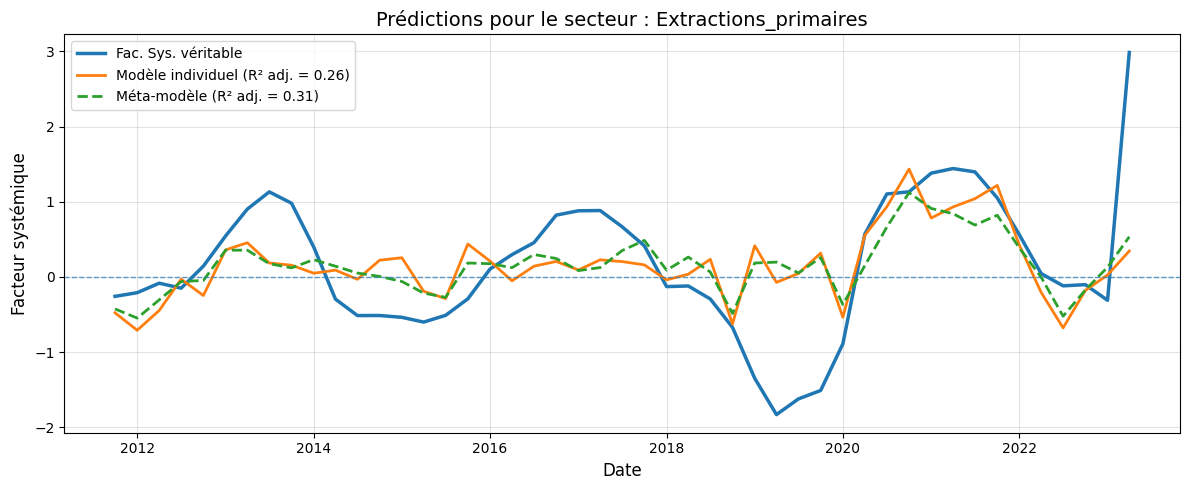

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_like_example(
    df,
    date_col="date",          # colonne date (datetime ou convertible)
    y_true_col="y_true",      # facteur systémique "véritable"
    y_indiv_col="y_indiv",    # prédiction d'un modèle individuel
    y_meta_col="y_meta",      # prédiction du méta-modèle (stacking/JMA)
    sector_name="Extractions_primaires",
    r2_indiv=None,            # si None -> calculé
    r2_meta=None,             # si None -> calculé
    title_prefix="Prédictions pour le secteur : ",
    figsize=(12, 5),
    savepath=None
):
    """
    Reproduit un graphe proche de ton exemple:
    - noir: y_true
    - bleu: y_indiv
    - rouge pointillé: y_meta
    - ligne horizontale y=0 en gris pointillé
    - légende avec R² adj (ici on met R² simple; si tu veux l'ajusté, passe-le via r2_*)

    df doit contenir au minimum: date_col, y_true_col, y_indiv_col, y_meta_col.
    """
    d = df[[date_col, y_true_col, y_indiv_col, y_meta_col]].copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna().sort_values(date_col)

    y_true = d[y_true_col].astype(float).values
    y_ind  = d[y_indiv_col].astype(float).values
    y_meta = d[y_meta_col].astype(float).values

    def r2(y, yhat):
        if len(y) < 2:
            return np.nan
        sse = np.sum((y - yhat) ** 2)
        sst = np.sum((y - np.mean(y)) ** 2)
        return np.nan if sst == 0 else 1 - sse / sst

    if r2_indiv is None:
        r2_indiv = r2(y_true, y_ind)
    if r2_meta is None:
        r2_meta = r2(y_true, y_meta)

    plt.figure(figsize=figsize)
    plt.plot(d[date_col], y_true, linewidth=2.5, label="Fac. Sys. véritable")
    plt.plot(d[date_col], y_ind,  linewidth=2.0, label=f"Modèle individuel (R² adj. = {r2_indiv:.2f})")
    plt.plot(d[date_col], y_meta, linewidth=2.0, linestyle="--",
             label=f"Méta-modèle (R² adj. = {r2_meta:.2f})")

    plt.axhline(0, linestyle="--", linewidth=1.0, alpha=0.7)
    plt.grid(True, alpha=0.35)

    plt.title(f"{title_prefix}{sector_name}", fontsize=14)
    plt.ylabel("Facteur systémique", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(loc="upper left", frameon=True)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


# ==========================
# EXEMPLE D’UTILISATION
# ==========================
# Tu peux construire df_plot à partir de tes objets:
# - Z observé : df_macro_stationary["Z_..."]
# - prédiction modèle individuel : yhat_best (Series)
# - prédiction méta-modèle : yhat_stacked (Series)

# Exemple type (adapte les noms):
y_col = y_col  # ou "Z_EXTRACTIONS_PRIMAIRES"
y_true = df_macro_stationary[y_col]
yhat_indiv =y_indiv_col           # Series indexée par date
yhat_meta = y_meta_col   # Series indexée par date
#
df_plot = pd.concat(
    [y_true.rename("y_true"),
     yhat_indiv.rename("y_indiv"),
     yhat_meta.rename("y_meta")],
    axis=1
).reset_index().rename(columns={"index": "date"})
#
plot_predictions_like_example(
    df_plot,
    date_col="date",
    y_true_col="y_true",
    y_indiv_col="y_indiv",
    y_meta_col="y_meta",
    sector_name="Extractions_primaires"
 )


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan

def add_lags(df: pd.DataFrame, cols, max_lag: int, prefix_map=None):
    """
    Ajoute des colonnes col_L1..col_Lmax_lag.
    prefix_map optionnel: dict col -> prefix string, sinon col name.
    """
    out = df.copy()
    for c in cols:
        pref = prefix_map.get(c, c) if prefix_map else c
        for L in range(1, max_lag + 1):
            out[f"{pref}_L{L}"] = out[c].shift(L)
    return out

def nw_lags_rule(T: int) -> int:
    # règle classique : floor(4*(T/100)^(2/9))
    return int(np.floor(4 * (T/100) ** (2/9)))

def fit_ols_hac(df_model: pd.DataFrame, y_col: str, x_cols, hac_lags=None):
    """
    Fit OLS + results HAC (Newey-West). Retourne dict avec ols/hac.
    """
    d = df_model[[y_col] + list(x_cols)].dropna()
    if d.shape[0] < (len(x_cols) + 5):  # garde-fou
        return None

    y = d[y_col]
    X = sm.add_constant(d[list(x_cols)], has_constant="add")
    ols = sm.OLS(y, X).fit()

    if hac_lags is None:
        hac_lags = nw_lags_rule(len(d))

    hac = ols.get_robustcov_results(cov_type="HAC", maxlags=hac_lags)
    return {"ols": ols, "hac": hac, "nobs": len(d), "hac_lags": hac_lags}

def residual_diagnostics_from_ols(ols_res, lb_lags=12, alpha=0.05):
    """
    Diagnostics sur les résidus OLS (l'autocorrélation ne disparaît pas avec HAC).
    """
    u = ols_res.resid
    # Ljung-Box
    lb = acorr_ljungbox(u, lags=[lb_lags], return_df=True)
    lb_p = float(lb["lb_pvalue"].iloc[0])

    # Breusch-Pagan (hétéroscédasticité)
    # BP exige exog avec constante
    bp_stat, bp_p, _, _ = het_breuschpagan(u, ols_res.model.exog)
    bp_p = float(bp_p)

    return {
        "LB_pvalue": lb_p,
        "LB_ok_5pct": lb_p > alpha,
        "BP_pvalue": bp_p,
        "BP_ok_5pct": bp_p > alpha
    }

def sign_constraints_ok(params: pd.Series, expected_sign: dict):
    """
    expected_sign: dict {var: +1/-1} ; ignore variables absentes.
    """
    for v, s in expected_sign.items():
        if v in params.index:
            if s > 0 and params[v] <= 0:
                return False
            if s < 0 and params[v] >= 0:
                return False
    return True

def hac_significance_ok(hac_res, x_cols, alpha=0.05, min_sig=1):
    pvals = pd.Series(hac_res.pvalues, index=hac_res.model.exog_names)
    vars_in = [v for v in x_cols if v in pvals.index]
    if not vars_in:
        return False
    return int((pvals[vars_in] < alpha).sum()) >= min_sig

In [ ]:
def make_ardl_design(df: pd.DataFrame, y_col: str, x_base_cols, p_max: int, q_max: int):
    """
    Retourne un df enrichi avec y_lags + x_lags.
    - y lags: y_L1..y_Lp_max
    - x lags: X_L0..X_Lq_max (L0 = contemporain)
    """
    out = df.copy()

    # lags de y
    out = add_lags(out, [y_col], p_max, prefix_map={y_col: y_col})

    # lags de X : on inclut L0 (= niveau contemporain) + L1..Lq_max
    # On garde les colonnes contemporaines telles quelles, et on ajoute les lags 1..q_max
    out = add_lags(out, x_base_cols, q_max)

    return out

In [ ]:
import itertools

def build_ardl_candidates(x_base_cols, p_set=(1,2), q_set=(0,1,2), max_x_in_model=None):
    """
    Génère des candidats:
    - sous-ensembles de X
    - p dans p_set
    - q dans q_set (même q pour toutes les X, et inclut X contemporains via L0)
    """
    if max_x_in_model is None:
        max_x_in_model = len(x_base_cols)

    candidates = []
    for k in range(1, max_x_in_model + 1):
        for x_subset in itertools.combinations(x_base_cols, k):
            for p in p_set:
                for q in q_set:
                    # construction des colonnes explicatives
                    x_cols = []

                    # y lags
                    for L in range(1, p + 1):
                        x_cols.append(f"{y_col}_L{L}")  # y_col doit exister dans le scope où tu appelles

                    # X lags: L0 = contemporain, + lags 1..q
                    for x in x_subset:
                        x_cols.append(x)  # L0
                        for L in range(1, q + 1):
                            x_cols.append(f"{x}_L{L}")

                    candidates.append({
                        "name": f"ARDL(p={p},q={q})|X={','.join(x_subset)}",
                        "x": x_cols,
                        "meta": {"p": p, "q": q, "x_subset": x_subset}
                    })
    return candidates

In [ ]:
def select_ardl_hac_models(
    df_design, y_col, candidate_models, expected_sign,
    lb_lags=12, alpha=0.05,
    hac_lags=None,  # None => règle auto sur T
    require_sig=False, sig_alpha=0.05, min_sig=1,
    enforce_bp=False, enforce_lb=False,   # par défaut: LB pas bloquant (car ARDL peut encore laisser un peu d'AC)
    top_n=20
):
    summary_rows = []

    for m in candidate_models:
        x_cols = m["x"]

        fit = fit_ols_hac(df_design, y_col, x_cols, hac_lags=hac_lags)
        if fit is None:
            continue

        ols = fit["ols"]
        hac = fit["hac"]

        ok_sign = sign_constraints_ok(pd.Series(ols.params, index=ols.model.exog_names), expected_sign)

        diag = residual_diagnostics_from_ols(ols, lb_lags=lb_lags, alpha=alpha)

        ok_sig = True
        if require_sig:
            ok_sig = hac_significance_ok(hac, x_cols, alpha=sig_alpha, min_sig=min_sig)

        ok_lb = diag["LB_ok_5pct"] if enforce_lb else True
        ok_bp = diag["BP_ok_5pct"] if enforce_bp else True

        ok = ok_sign and ok_lb and ok_bp and ok_sig

        summary_rows.append({
            "model": m.get("name", str(tuple(x_cols))),
            "x_cols": tuple(x_cols),
            "ok": ok,
            "k": len(x_cols),
            "nobs": fit["nobs"],
            "hac_lags": fit["hac_lags"],
            "aic": ols.aic,
            "bic": ols.bic,
            "r2_adj": ols.rsquared_adj,
            "ok_sign": ok_sign,
            "ok_lb": ok_lb,
            "ok_bp": ok_bp,
            "ok_sig": ok_sig,
            **diag,
            **m.get("meta", {})
        })

    summary = pd.DataFrame(summary_rows)
    if summary.empty:
        return [], summary

    summary_ok = summary[summary["ok"]].copy()
    summary_top = summary_ok.sort_values("aic").head(top_n)

    kept = [m for m in candidate_models if tuple(m["x"]) in set(summary_top["x_cols"])]

    summary = summary.sort_values(["ok", "aic"], ascending=[False, True])
    return kept, summary

In [ ]:
# 0) df : index = date (datetime), colonnes y + X
df = df.sort_index()
df.index = pd.to_datetime(df.index)

y_col = "Zt"  # ou ton y
x_base_cols = [
    "US_Central_bank_Intervention_rate_policy_interest_rate",
    "US_Effective_exchange_rate",
    "US_Equity_prices",
    "US_GDP_Growth_Rate",
    "US_House_prices_residential",
    "US_Inflation_rate",
    "US_Long_term_interest_rate",
    "US_Oil_price",
    "US_Unemployment_rate"
]

# 1) construire le design ARDL (choix des max lags)
p_max = 4   # y lags max
q_max = 4   # X lags max

df_design = make_ardl_design(df, y_col=y_col, x_base_cols=x_base_cols, p_max=p_max, q_max=q_max)

# 2) générer les candidats (choix p,q testés)
candidate_models = build_ardl_candidates(
    y_col=y_col,
    x_base_cols=x_base_cols,
    p_set=(1,2,3,4),
    q_set=(0,1,2,3,4),
    max_x_in_model=3  # important pour éviter explosion combinatoire
)

# 3) contraintes de signe (sur les noms EXACTS des variables utilisées)
# Attention: ici, on contraint seulement les contemporains X (L0),
# mais tu peux aussi contraindre certains lags si tu veux.
expected_sign = {
    "US_Inflation_rate": +1,
    "US_Unemployment_rate": -1,
    # etc...
}

# 4) sélection HAC
kept, summary = select_ardl_hac_models(
    df_design, y_col, candidate_models, expected_sign,
    lb_lags=12, alpha=0.05,
    hac_lags=None,              # auto rule
    require_sig=True, sig_alpha=0.05, min_sig=1,
    enforce_bp=False,
    enforce_lb=False,           # recommandé si ton but est l'inférence HAC
    top_n=20
)

summary.head(30)
len(kept)